In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Input, Dense, Reshape, Conv2DTranspose,\
    Activation, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import cv2
import time
from tensorflow.keras.utils import Sequence
%matplotlib inline

In [2]:
devices=tf.config.experimental.list_physical_devices('GPU')
print("GPUS: ", len(devices))
tf.config.experimental.set_memory_growth(devices[0],True)

GPUS:  1


In [5]:
class DataGenerator(Sequence):

  def __init__(self, base_dir,base_dir2, output_size, shuffle=False, batch_size=10):
    self.base_dir = base_dir
    self.base_dir2 = base_dir2
    self.output_size = output_size
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.all_x = os.listdir(base_dir)
    self.all_y = os.listdir(base_dir2)
    self.on_epoch_end()

  def on_epoch_end(self):
    self.indices = np.arange(len(self.all_x))
    if self.shuffle:
      np.random.shuffle(self.indices)

  def __len__(self):
    return int(len(self.all_x) / self.batch_size)

  def __getitem__(self, idx):
    X = np.empty((self.batch_size, *self.output_size, 3))
    Y = np.empty((self.batch_size, *self.output_size, 3))

    indices = self.indices[idx*(self.batch_size): (idx+1)*(self.batch_size)]
    

    for i,j in enumerate(indices):
      img_path = os.path.join(self.base_dir,self.all_x[j])
      img_path2 = os.path.join(self.base_dir2,self.all_y[j])
        
      img  = cv2.imread(img_path)
      img= cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2RGB),self.output_size)
      img2 = cv2.imread(img_path2)
      img2= cv2.resize(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB),self.output_size)
#       print(img_path,img_path2)

      X[i,] = img
      Y[i,] = img2
    X= X.astype('float32')/255
    Y= Y.astype('float32')/255

    return X, Y

In [7]:
def plotImages(images_arr):
  fig,axes = plt.subplots(1,10,figsize=(20,20))
  axes=axes.flatten()
  for img,ax in zip(images_arr,axes):
    img=img*255
    img=img.astype(np.uint)
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()

In [6]:
train = DataGenerator('data/train_x/train_x','data/train_y/train_y',(64,64), batch_size=128, shuffle=False)
test  = DataGenerator('data/test_x/test_x','data/test_y/test_y',(64,64), batch_size=128, shuffle=False)

In [ ]:
xx,yy=train[32]
plotImages(xx)
plotImages(yy)

In [5]:
def conv_operation(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def conv_transpose_operation(x, filters, kernel_size):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=2,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

def deblurring_autoencoder():
   dae_inputs = Input(shape=(64,64,3), name='dae_input')
   conv_block1 = conv_operation(dae_inputs, 32, 3)
   conv_block2 = conv_operation(conv_block1, 64, 3)
   conv_block3 = conv_operation(conv_block2, 128, 3)
   conv_block4 = conv_operation(conv_block3, 256, 3)
   
   conv_block5 = conv_operation(conv_block4, 256, 3, 1)

   deconv_block1 = conv_transpose_operation(conv_block5, 256,3)
   merge1 = Concatenate()([conv_block3,deconv_block1])
   deconv_block2 = conv_transpose_operation(merge1, 128, 3)
   merge2 = Concatenate()([deconv_block2, conv_block2])
   deconv_block3 = conv_transpose_operation(merge2, 64, 3)
   merge3 = Concatenate()([deconv_block3, conv_block1])
   deconv_block4 = conv_transpose_operation(merge3, 32, 3)

   final_deconv = Conv2DTranspose(filters=3, kernel_size=3,padding='same')(deconv_block4)

#    dae_outputs = Activation('sigmoid', name='dae_output')(final_deconv)
   
   return Model(dae_inputs, final_deconv, name='dae')

In [6]:
model= deblurring_autoencoder()

In [7]:
model.summary()

Model: "dae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dae_input (InputLayer)          [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         dae_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 32, 32, 32)   0           batch_normalization[0][0]        
________________________________________________________________________________________________

In [8]:
opt=Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

In [9]:

callbacks=[
    ModelCheckpoint('deblur_my_shit.h5',verbose=1,save_best_only=True,save_weights_only=True)
]

In [10]:
model.fit(
    train,
    epochs=20,
    verbose=1,
    callbacks=callbacks
)

  ...
    to  
  ['...']
Train for 78 steps
Epoch 1/20
78/78 [==============================] - 104s 1s/step - loss: 0.1752 - mae: 0.2904
Epoch 2/20
78/78 [==============================] - 19s 241ms/step - loss: 0.0305 - mae: 0.1298
Epoch 3/20
78/78 [==============================] - 20s 253ms/step - loss: 0.0208 - mae: 0.1082
Epoch 4/20
78/78 [==============================] - 21s 263ms/step - loss: 0.0167 - mae: 0.0971
Epoch 5/20
78/78 [==============================] - 21s 271ms/step - loss: 0.0142 - mae: 0.0899
Epoch 6/20
78/78 [==============================] - 22s 280ms/step - loss: 0.0127 - mae: 0.0854
Epoch 7/20
78/78 [==============================] - 22s 284ms/step - loss: 0.0118 - mae: 0.0818
Epoch 8/20
78/78 [==============================] - 22s 287ms/step - loss: 0.0108 - mae: 0.0791
Epoch 9/20
78/78 [==============================] - 23s 290ms/step - loss: 0.0101 - mae: 0.0764
Epoch 10/20
78/78 [==============================] - 23s 297ms/step - loss: 0.0095 - mae: 0.07

In [11]:
keras.models.save_model(
    model,'best_model'
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model\assets


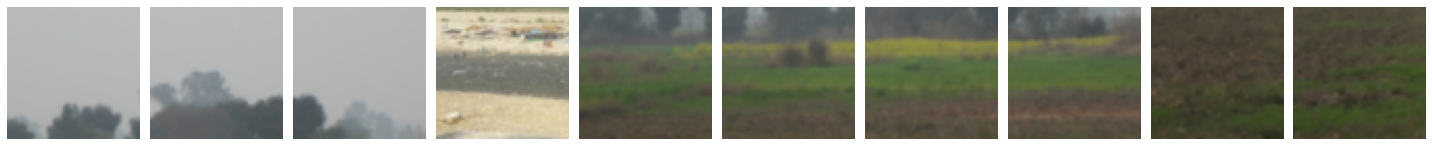

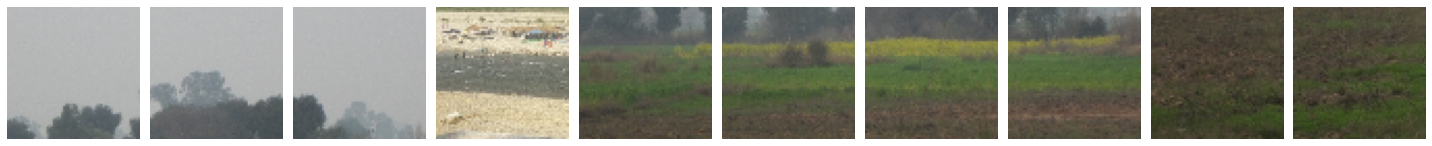

In [8]:
xx,yy= test[4]  #randomly chosen
plotImages(xx)
plotImages(yy)

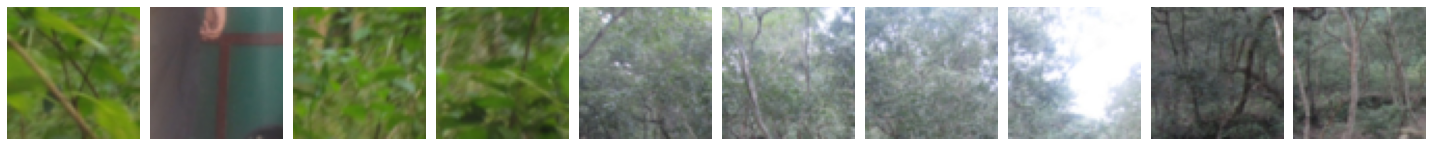

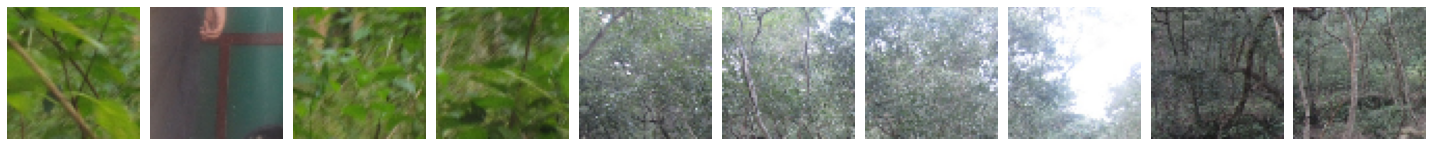

In [15]:
xx,yy=train[6]

plotImages(xx)
plotImages(yy)

In [4]:
model=keras.models.load_model('best_model/')

In [16]:
prediction= model.predict(xx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


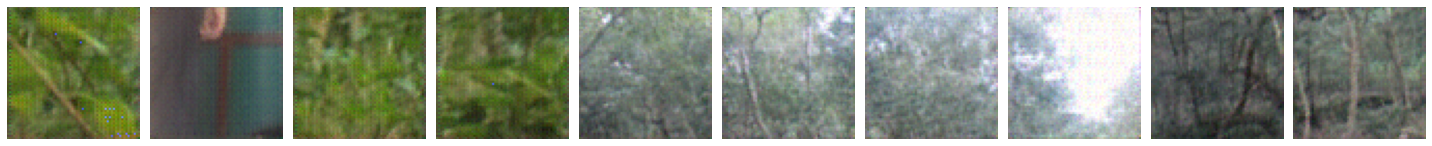

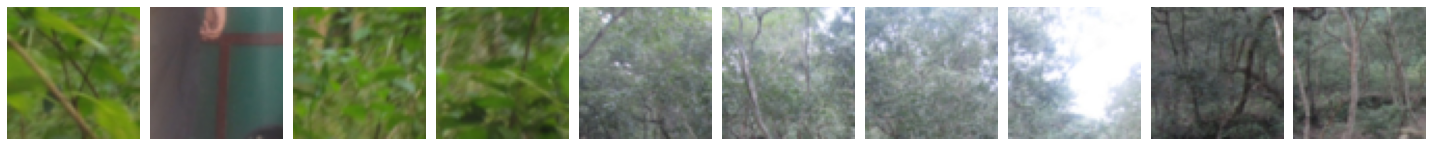

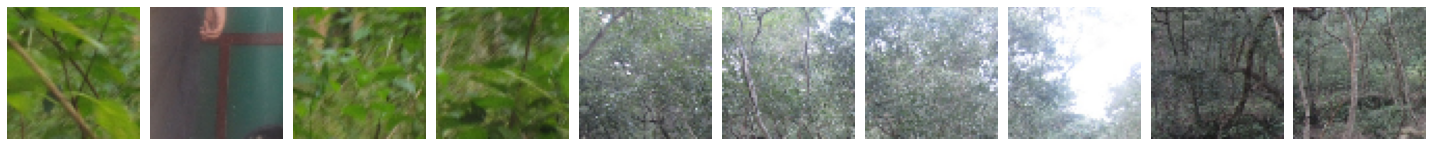

In [17]:
plotImages(prediction)
plotImages(xx)
plotImages(yy)